<a href="https://colab.research.google.com/github/AyeCh-Ytr/AyeCh-maker/blob/main/faceemotiondetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.shape

(35887, 3)

In [ ]:
labels = data.iloc[:, 0]

In [ ]:
pixels = data.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])

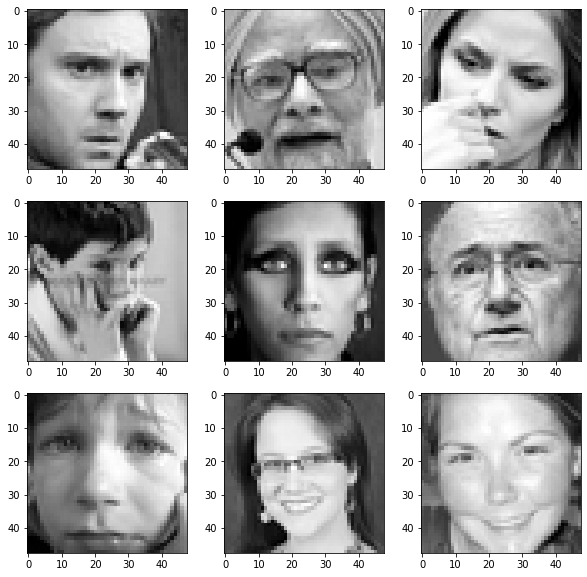

In [ ]:
plt.figure(figsize = (10,10))
for index,image in enumerate(images[:9]):
    plt.subplot(3,3,index+1)
    plt.imshow(image.reshape((48,48)), cmap = 'gray')
plt.show()

In [ ]:
train_or_test = data.iloc[:, 2].values
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1

In [ ]:
reshaped_images.shape

(35887, 48, 48, 1)

In [ ]:
norm_images = reshaped_images / 255.0

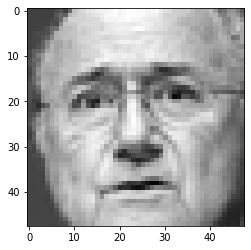

In [ ]:
plt.imshow(norm_images[5].reshape((48,48)), cmap="gray")
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
new_labels = to_categorical(labels, num_classes=7)
new_labels.shape

(35887, 7)

In [ ]:
reshaped_images.shape

(35887, 48, 48, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))
opt = Adam(lr = 0.0005)

model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss', 
                             mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs = epochs)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.6986 - accuracy: 0.3511
Epoch 1: saving model to fer_model.h5
898/898 [==============================] - 1680s 2s/step - loss: 1.6986 - accuracy: 0.3511 - val_loss: 1.5820 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.3581 - accuracy: 0.4788
Epoch 2: saving model to fer_model.h5
898/898 [==============================] - 1661s 2s/step - loss: 1.3581 - accuracy: 0.4788 - val_loss: 1.2437 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.5285
Epoch 3: saving model to fer_model.h5
898/898 [==============================] - 1653s 2s/step - loss: 1.2367 - accuracy: 0.5285 - val_loss: 1.1829 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - ETA: 0s - loss: 1.1713 - accuracy: 0.5542
Epoch 4: saving model to fer_model.h5
898/898 [=================

In [ ]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [ ]:
import PIL
from PIL import Image
import cv2
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt


In [ ]:
json_file = open("model.json", "r")
loaded_json_model = json_file.read()
json_file.close()

model = model_from_json(loaded_json_model)
model.load_weights("model_weights.h5")

In [ ]:
img = cv2.imread("/content/drive/MyDrive/face detection project/face data train test/test/angry/PrivateTest_10131363.jpg")

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [ ]:
img.shape

In [ ]:
img = cv2.resize(img, (48,48))

In [ ]:
max_index = np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]

                  
predicted_emotion = emotions[max_index]  
print(f'predicted emotion is {predicted_emotion}')

In [ ]:
model.save("Fer_Model.h5")

In [ ]:
model.save_weights("model_weights.h5")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)